In [2]:
import uproot
import numpy as np

file1 = uproot.open(f'/storage/data/48PMT/bipo/20230222/run0/tier1/output_dt2.root')
timestamps1 = np.array(file1['eventTree']['timestamp'].array())

file2 = uproot.open(f'/storage/data/48PMT/bipo/20230222/run1/tier1/output_dt2.root')
timestamps2 = np.array(file2['eventTree']['timestamp'].array())

file3 = uproot.open(f'/storage/data/48PMT/bipo/20230223/run0/tier1/output_dt2.root')
timestamps3 = np.array(file3['eventTree']['timestamp'].array())

In [ ]:
timestamps2

In [3]:
ch = 1
timestamps = np.append(timestamps1[:,ch], timestamps2[:,ch])
timestamps = np.append(timestamps, timestamps3[:,ch])
timestamps = timestamps*8e-9

Nmeds=10
left_shift=100
    
diffs = np.diff(timestamps[left_shift:])
upper_cut = Nmeds*np.median(diffs[diffs>0])
mask = np.logical_and(diffs < upper_cut, diffs > 0)
diffs_masked = diffs[mask]


In [ ]:
d0e1 d863 eecd

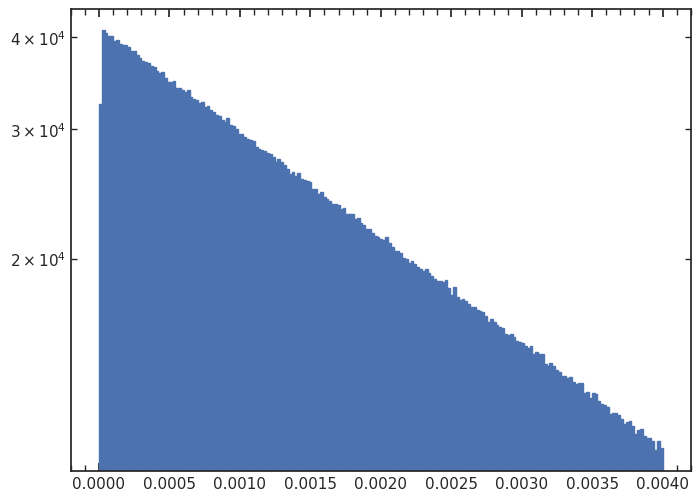

In [48]:
fig, ax = plt.subplots(figsize = (8, 6))

n, edges,_ = ax.hist(diffs_masked, bins = np.linspace(0, 200e-6*20, 200), fc = 'b', ec = 'b')
centers = (edges[1:]+edges[:-1])/2.
ax.set_yscale('log')

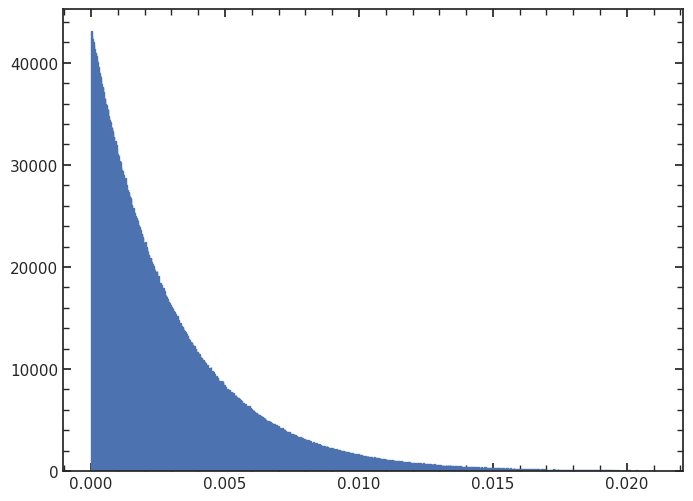

In [4]:
fig, ax = plt.subplots(figsize = (8, 6))

n, edges,_ = ax.hist(diffs_masked, bins = np.linspace(1e-5, diffs_masked.max(), 1000), fc = 'b', ec = 'b')
centers = (edges[1:]+edges[:-1])/2.

In [5]:
def my_func(ts, a1, tau1, a2, tau2, c):

    a1*np.exp(-ts/tau1)+a2*np.exp(-ts/tau2)+c

    return a1*np.exp(-ts/tau1)+a2*np.exp(-ts/tau2)+c

def chi2(x, mu):
    return ((x-mu)**2/mu).sum()

import iminuit


t_min = 0
t_max = 0.1

mask_fit = np.logical_and(centers>=t_min, centers<=t_max)

def cost_function(theta):
    a1, tau1, a2, tau2, c = theta
    # print(theta)
    y = my_func(centers[mask_fit], a1, tau1, a2, tau2, c)
    return chi2(n[mask_fit], y)

# theta0 = 2000, 0.003, 10, 164e-6/np.log(2), 0.
theta0 = 40000, 0.00301, 30, 164e-6/np.log(2), 0.42
param_names = ['a1', 'tau1', 'a2', 'tau2', 'c']
m = iminuit.Minuit(cost_function, theta0, name = param_names)

m.limits['a1'] = (0, None)
m.limits['a2'] = (0, None)
m.limits['tau1'] = (0, None)
m.limits['tau2'] = (1e-4, 1e-3)
m.limits['c'] = (0, None)

m.errordef = m.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 930.2                      │              Nfcn = 278              │
│ EDM = 4.05e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │  43.26e3  │  0.04e3   │            │            │    0    │         │       │
│ 1 │ tau1 │ 3.0315e-3 │ 0.0020e-3 │            │            │    0    │         │       │
│ 2 │ a2   │    50     │    50     │            │            │    0    │         │       │
│ 3 │ tau2 │  0.6e-3   │  0.7e-3   │            │            │ 0.0001  │  0.001  │       │
│ 4 │ c    │    0.6    │    0.7    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬───────────────────────────────────────────────────┐
│      │        a1      tau1        a2      tau2         c │
├──────┼───────────────────────────────────────────────────┤
│   a1 │  1.97e+03 -7.67e-05 -2.69e+03   -0.0138      13.1 │
│ tau1 │ -7.67e-05  4.07e-12  0.000104  4.61e-10 -8.71e-07 │
│   a2 │ -2.69e+03  0.000104  7.86e+03   0.00228     -18.1 │
│ tau2 │   -0.0138  4.61e-10   0.00228  4.43e-07 -7.16e-05 │
│    c │      13.1 -8.71e-07     -18.1 -7.16e-05     0.497 │
└──────┴───────────────────────────────────────────────────┘

In [80]:
# def cost_function(theta):
#     return -2*ll_unbinned(theta, diffs_masked)

# param0 = np.array([len(diffs_masked), 0.00301, 50., 164e-6/np.log(2), 2]) 
# m = iminuit.Minuit(cost_function, param0, name = param_names)
# m.limits['a1'] = (0, None)
# m.limits['a2'] = (0, None)
# m.limits['tau1'] = (0, None)
# m.limits['tau2'] = (1e-4, 1e-3)
# m.limits['c'] = (0, None)

# m.errordef = m.LEAST_SQUARES
# m.migrad()

/tmp/ipykernel_2431684/946553875.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
/tmp/ipykernel_2431684/946553875.py:8: RuntimeWarning: invalid value encountered in divide
  f1 = np.exp(-ts/tau1)/np.exp(-bins/tau1).sum()


KeyboardInterrupt: 

In [6]:
from scipy.stats import poisson

# import warnings
# warnings.filterwarnings("error")

def model(ts, a1, tau1, a2, tau2, c):
    bins = np.linspace(ts.min(), ts.max(), 10000)
    f1 = np.exp(-ts/tau1)/np.exp(-bins/tau1).sum()
    f2 = np.exp(-ts/tau2)/np.exp(-bins/tau2).sum()
    f3 = c/(c*np.ones(bins.shape)).sum()
    return (a1*f1 + a2*f2 + c)/(a1+a2+c)

def log_prior_gauss(param, mean, sigma):
    # + np.log(1./(np.sqrt(2*np.pi)*sigma)) # This is a just a constant
    return -0.5*(param-mean)**2/sigma**2

def log_prior(theta):
    lp = 0.

    # lp += 

    for param in theta:
        if param <= 0: return -np.inf

    if not np.isfinite(lp):
        # print(f'{param} value not allowed by prior: {named_theta[param]}')
        return -np.inf
    return lp


# def ll_unbinned(theta, evts):
#     mu = theta[0]+theta[2]+theta[4]

#     try:
#         integral = model(np.linspace(evts.min(), evts.max(), 10000), *theta)
#         probs = model(evts, *theta)/integral.sum()

#         # plt.plot(evts, probs)

#         ll = np.log(probs).sum()

#         rv = poisson(mu)
#         N_exp = len(evts)
#         prob = rv.pmf(N_exp)
#         ln = np.log(prob)
#         ll_tot = ll + ln
#         if not np.isfinite(ll_tot):
#             return -np.inf
#         else:
#             return ll_tot
        
#     except RuntimeWarning as e:
#         print(e)
#         print(theta)
#         return -np.inf
    
def ll_unbinned(theta, evts):
    mu = theta[0]+theta[2]+theta[4]

    if True:
        probs = model(evts, *theta)

        # plt.plot(evts, probs)

        ll = np.log(probs).sum()

        rv = poisson(mu)
        N_exp = len(evts)
        prob = rv.pmf(N_exp)
        ln = np.log(prob)
        ll_tot = ll + ln
        if not np.isfinite(ll_tot):
            return -np.inf
        else:
            return ll_tot
        
    # except RuntimeWarning as e:
    #     print(e)
    #     print(theta)
    #     return -np.inf

def posterior(theta, evts):
    
    lp = log_prior(theta)

    if not np.isfinite(lp):
        return -np.inf
    else:
        ll = ll_unbinned(theta, evts)
        if not np.isfinite(ll):
            return -np.inf
        else:
            ltot = ll + lp
            return ltot

import emcee
# # param0 = np.asarray(m.values) 
param0 = np.array([len(diffs_masked), 0.00301, 50., 164e-6/np.log(2), 2]) 
init_params = param0 + 1e-3*np.asarray(param0) * np.random.randn(2*len(param0), len(param0))
nwalkers, ndim = init_params.shape
n_samples = 5000
print(f'Param. space dim.: {ndim}')
print(f'Number of walkers: {nwalkers}')
print(f'Number of samples: {n_samples}')

parallel = True
if parallel:#platform == "linux" or platform == "linux2":
    # print('Running on Linux: enabling parallelization')
    from multiprocessing import Pool
    with Pool(processes = nwalkers) as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior, pool = pool, args = [diffs_masked])
        sampler.run_mcmc(init_params, n_samples, progress=True)


Param. space dim.: 5
Number of walkers: 10
Number of samples: 5000


  0%|          | 25/5000 [00:32<1:49:29,  1.32s/it]/tmp/ipykernel_2575352/2474323373.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
  1%|          | 27/5000 [00:35<1:49:21,  1.32s/it]/tmp/ipykernel_2575352/2474323373.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
  1%|          | 34/5000 [00:44<1:48:29,  1.31s/it]/tmp/ipykernel_2575352/2474323373.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
  1%|          | 37/5000 [00:48<1:49:23,  1.32s/it]/tmp/ipykernel_2575352/2474323373.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
  1%|          | 41/5000 [00:53<1:48:45,  1.32s/it]/tmp/ipykernel_2575352/2474323373.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
  1%|          | 44/5000 [00:57<1:49:00,  1.32s/it]/tmp/ipykernel_2575352/2474323373.py:70: RuntimeWarning: divide by zero encountered in log
  ln = np.log(prob)
  1%|          | 51/5000 [01

KeyboardInterrupt: 

-23513718.12088026


-23542942.160062645

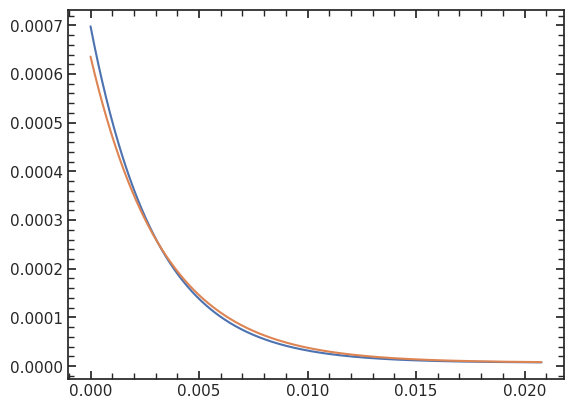

In [74]:
print(posterior(param0, np.sort(diffs_masked)))
params = np.copy(param0)
which = 1
params[which] = params[which]*(1+0.1)
posterior(params, np.sort(diffs_masked))

In [43]:
scale = 0.01
biases = np.linspace(-scale, scale, 31)
lls = []
which = 4
param0 = np.array([len(diffs_masked), 0.00304, 1., 164e-6/np.log(2), 10000])
for bias in biases:
    params = np.copy(param0)
    params[which] = params[which]*(1+bias)
    ll = posterior(params, diffs_masked)
    lls.append(ll)

lls = np.asarray(lls)

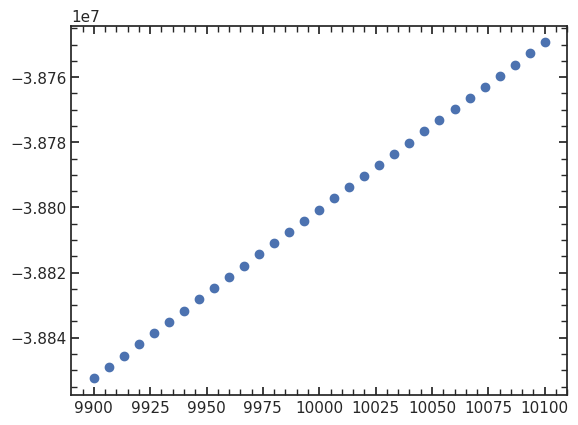

In [44]:
plt.scatter(param0[which]*(1+biases), lls)

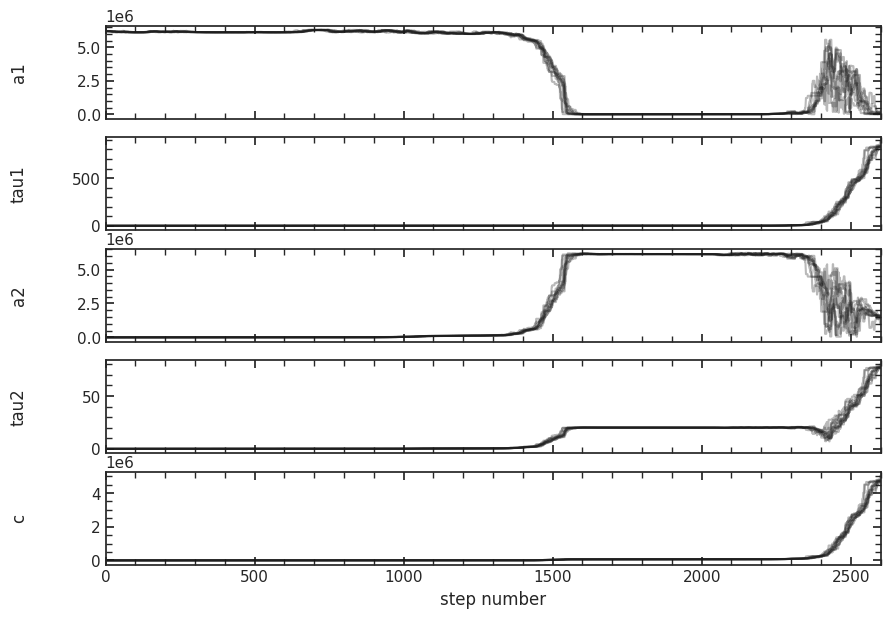

In [7]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a1", "tau1", "a2", "tau2", "c"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [10]:
ll_unbinned(param0, diffs_masked)

-23664508.5843177

In [11]:
164e-6/np.log(2)

0.00023660198670579

In [12]:
m.values

<ValueView a1=19941.90280844739 tau1=0.0029916540671321495 a2=40.86597270072906 tau2=0.00029357838004166184 c=0.27616222365337606>

In [13]:
def my_func(ts, a1, tau1, c):
    return a1*np.exp(-ts/tau1)+c

def chi2(x, mu):
    return ((x-mu)**2/mu).sum()

import iminuit


t_min = 1e-2
t_max = 0.1

mask_fit = np.logical_and(centers>=t_min, centers<=t_max)

def cost_function(theta):
    a1, tau1, c = theta
    # print(theta)
    y = my_func(centers[mask_fit], a1, tau1, c)
    return chi2(n[mask_fit], y)

theta0 = 2000, 0.003, 0.
param_names = ['a1', 'tau1', 'c']
m = iminuit.Minuit(cost_function, theta0, name = param_names)

m.limits['a1'] = (0, None)
m.limits['tau1'] = (0, None)
m.limits['c'] = (0, None)

m.errordef = m.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 432.9                      │              Nfcn = 270              │
│ EDM = 5.01e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │  19.9e3   │   0.6e3   │            │            │    0    │         │       │
│ 1 │ tau1 │ 2.990e-3  │ 0.025e-3  │            │            │    0    │         │       │
│ 2 │ c    │    0.7    │    0.9    │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬────────────────────────────┐
│      │       a1     tau1        c │
├──────┼────────────────────────────┤
│   a1 │ 3.97e+05  -0.0159      519 │
│ tau1 │  -0.0159 6.45e-10 -2.2e-05 │
│    c │      519 -2.2e-05    0.973 │
└──────┴────────────────────────────┘

In [14]:
1/3.010e-3	

332.22591362126246

(0.0, 0.00128)

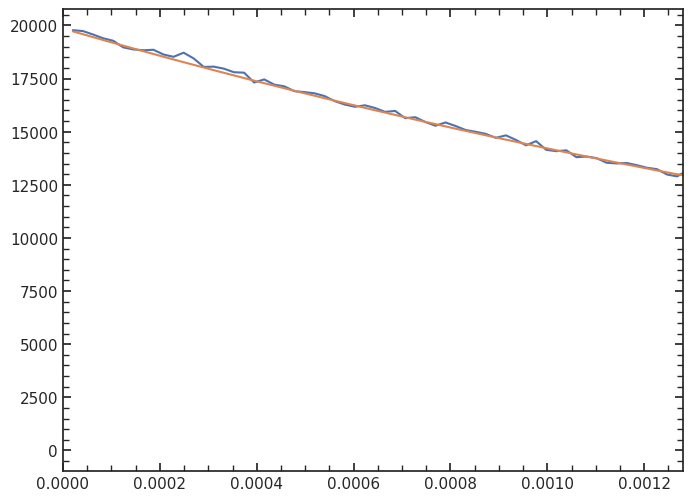

In [15]:
fig, ax = plt.subplots(figsize = (8, 6))
# a1, tau1, a2, tau2, c = m.values
a1, tau1, c = m.values

ax.plot(centers, n)
# ax.plot(centers, a1*np.exp(-centers/tau1))
ax.plot(centers, my_func(centers, *m.values))
ax.set_xlim(0, 160e-6*8)

In [16]:
def my_func(ts, a1, tau1):
    return a1*np.exp(-ts/tau1)

def chi2(x, mu):
    return ((x-mu)**2/mu).sum()

import iminuit


t_min = 0
t_max = 0.002

mask_fit = np.logical_and(centers>=t_min, centers<=t_max)

def cost_function(theta):
    a1, tau1 = theta
    # print(theta)
    y = my_func(centers[mask_fit], a1, tau1)+ 1939.4395590083384*np.exp(-centers[mask_fit]/0.0030102146975778347)+0.41786164731645326
    return chi2(n[mask_fit], y)

theta0 = 100, 236e-6
param_names = ['a1', 'tau1']
m = iminuit.Minuit(cost_function, theta0, name = param_names)

m.limits['a1'] = (0, None)
m.limits['tau1'] = (0, None)

m.errordef = m.LEAST_SQUARES
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 73.7                       │              Nfcn = 211              │
│ EDM = 6.98e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a1   │ 18.023e3  │  0.032e3  │            │            │    0    │         │       │
│ 1 │ tau1 │ 2.977e-3  │ 0.015e-3  │            │            │    0    │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────┬─────────────────────┐
│      │        a1      tau1 │
├──────┼─────────────────────┤
│   a1 │       996 -0.000389 │
│ tau1 │ -0.000389  2.13e-10 │
└──────┴─────────────────────┘

ValueError: not enough values to unpack (expected 5, got 2)

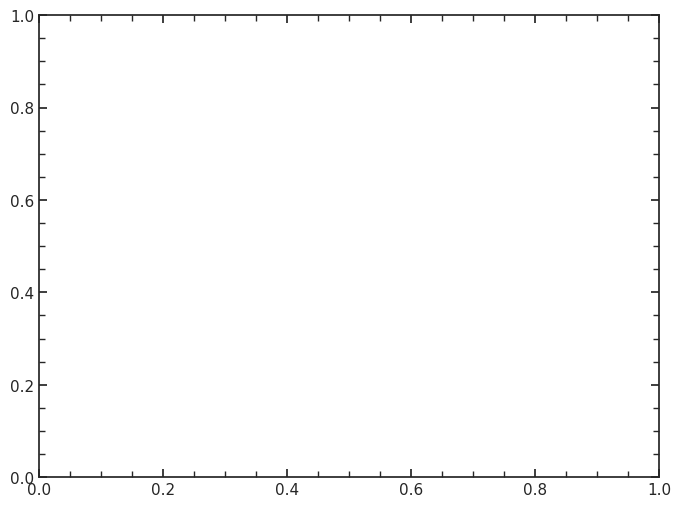

In [17]:
fig, ax = plt.subplots(figsize = (8, 6))
a1, tau1, a2, tau2, c = m.values

ax.plot(centers, n)
ax.plot(centers, a1*np.exp(-centers/tau1))
ax.plot(centers, my_func(centers, *m.values))
# ax.set_xlim(0, 160e-6*8)

In [ ]:
import uproot
import json
import numpy as np
from vis_functions import *
from rate_estim import *
from tqdm import tqdm

notebook_type = "rates"
params_file = open("/home/juno/arsgav/params.json")
PARAMS = json.load(params_file)
PARAMS['type'] = notebook_type

neptune_run = False
if neptune_run:
    run = neptune.init_run(
        project="legnaro/LegnaroSetup",
        api_token=PARAMS['api_token'],
        tags=[
            PARAMS['path'],
            PARAMS['run_numbers'],
            PARAMS['source_names'],
            PARAMS['output_file'],
            notebook_type,
        ],
        name="LNL",
    )
    
    del PARAMS['api_token']    
    run['PARAMS'] = PARAMS

In [ ]:
runs_list = ["run0 - Bkg"]

In [ ]:
run_numbers = PARAMS['run_numbers'].split(', ')
path = PARAMS['path']
output_file = PARAMS['output_file']
left_shift = int(PARAMS['left_shift'])

In [ ]:
path

'/storage/data/48PMT/bipo/20230222/'

In [ ]:
rates_array = []
fit_params_array = []
distrs_array = []

channel_number = np.random.randint(45)
rate_estim_outputs = np.array(
    [rate_estim(path, run_number, output_file, channel_number, Nmeds=10, left_shift=left_shift) for run_number in run_numbers],
    dtype=object
)

rates = rate_estim_outputs[:, 0]
fit_params = rate_estim_outputs[:, 1]
distrs = rate_estim_outputs[:, 2]
channel_number

10

## Rates visualization: 

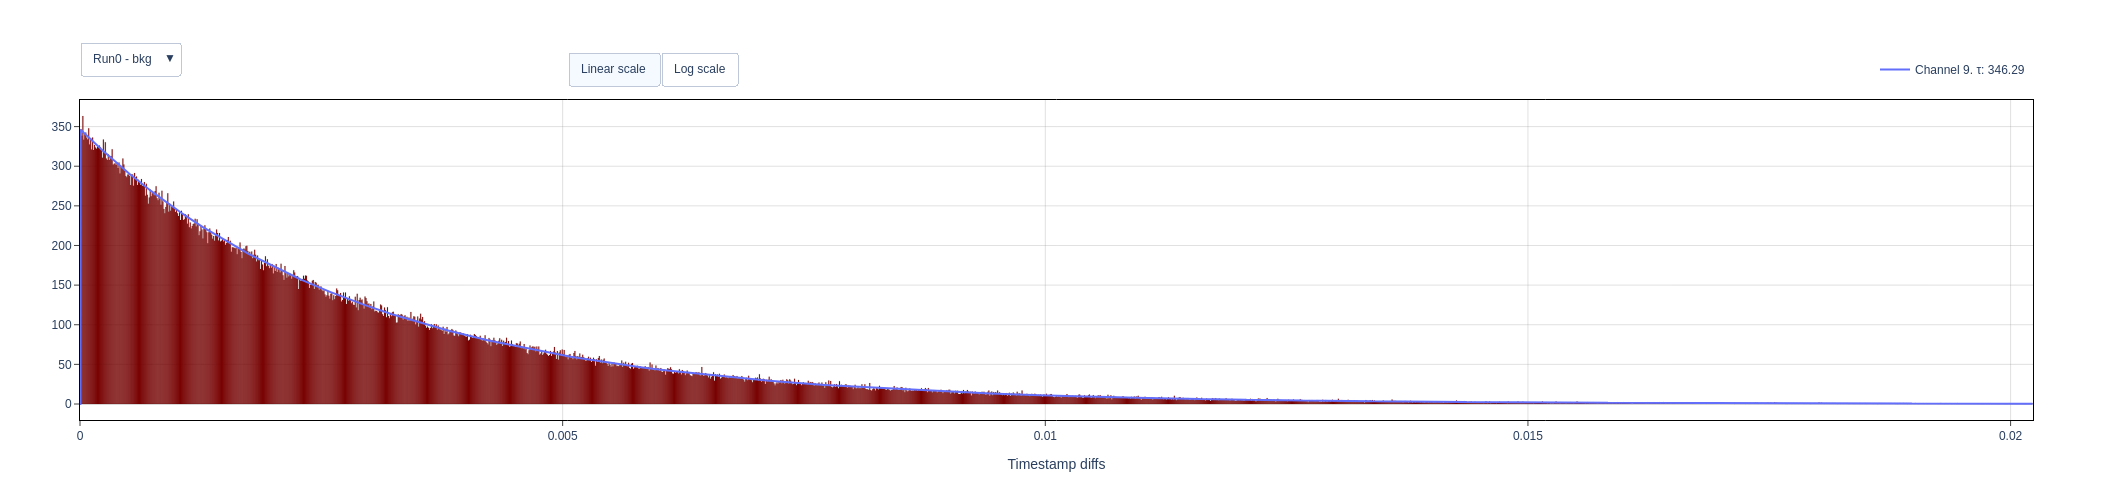

In [ ]:
if neptune_run:
    rates_fit_plots(run_numbers, runs_list, distrs, fit_params, rates, channel_number,
                    Nbins=1000, line_width=0.1, height=500, width=950,
                    neptune_run=neptune_run, run=run,
                    run_plot_name=f"Rate by channel for {PARAMS['run_numbers']} runs")
else:
    rates_fit_plots(run_numbers, runs_list, distrs, fit_params, rates, channel_number,
                    Nbins=1000, line_width=0.1, height=500, width=950,)

In [ ]:
if neptune_run:
    run.stop()